In [236]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fname = "GG_Skim.root" #/hdfs/store/user/kaho/NanoPost1/SingleMuon/SingleMuon_Run2017C-UL2017/210727_235847/0000/tree_50.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

In [237]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

E_collections = emevents.Electron
M_collections = emevents.Muon

#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents = emevents[opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj

M_collections = M_collections[M_collections.Target==1]
trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)
emevents = emevents[trg_Match]

emu = emevents.Muon[:,0] + emevents.Electron[:,0]


In [238]:
del events
del emevents
del emu

In [239]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("mass", "e_mu mass", 50, 110, 160),
        )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emu = emevents.Muon[:,0] + emevents.Electron[:,0]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=emu.mass, #emuevents.emMass,
            #weight=numpy.ones(len(emu.mass))
        )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [251]:
import glob
import os
import time
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
fsetGG = glob.glob('/hdfs/store/user/kaho/NanoPost1/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/*/*/*/*root')
fsetSigMu = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

samples = {
    "GGToEMu": fsetGG,
    "Single Mu": fsetSigMu
}

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/358 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/columnar/lib64/python3.6/site-packages/awkward/_util.py:347: ResourceWarning: unclosed file <_io.BufferedRandom name='output.root'>
  if not any(s is None for s in signature):
/afs/hep.wisc.edu/user/kaho/NDHiggs/columnar/lib64/python3.6/site-packages/awkward/_connect/_numpy.py:181: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs
/afs/hep.wisc.edu/user/kaho/NDHiggs/columnar/lib64/python3.6/site-packages/awkward/_connect/_numpy.py:181: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs


Elapsed time: 140.73315382003784


<AxesSubplot:xlabel='e_mu mass', ylabel='Events'>

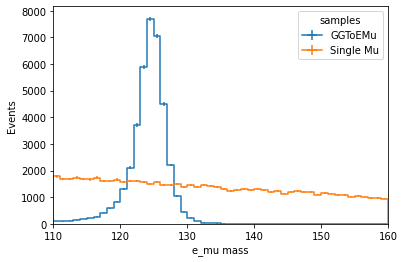

In [252]:
%matplotlib inline

hist.plot1d(result)

In [253]:
import uproot3
fout = uproot3.recreate('output.root')
a = result['Single Mu'].to_boost()
b = (a.to_numpy()[0][0], a.to_numpy()[-1])
fout['Single Mu'] = b
#fout['Single Mu'].show()
fout.close()

In [254]:
fout = uproot3.open('output.root')
fout['Single Mu'].show()
fout.close()

                 0                                                          1868
                 +-------------------------------------------------------------+
[-inf, 110) 0    |                                                             |
[110, 111)  1779 |**********************************************************   |
[111, 112)  1695 |*******************************************************      |
[112, 113)  1677 |*******************************************************      |
[113, 114)  1738 |*********************************************************    |
[114, 115)  1674 |*******************************************************      |
[115, 116)  1666 |******************************************************       |
[116, 117)  1737 |*********************************************************    |
[117, 118)  1615 |*****************************************************        |
[118, 119)  1608 |*****************************************************        |
[119, 120)  1661 |**********